In [11]:
import mnist_reader

import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
%matplotlib inline
import platform

In [12]:
platform.architecture()

('64bit', 'WindowsPE')

In [13]:
X_train, y_train = mnist_reader.load_mnist('fashion-mnist-master/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist-master/data/fashion', kind='t10k')

In [14]:
X_train.shape

(60000, 784)

In [15]:
labelsDict = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

In [16]:
labelsDict[y_train[0]]

'Ankle boot'

# image as data

Dress


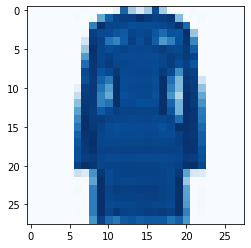

In [17]:
ind=500
print (labelsDict[y_train[ind]])
plt.imshow(np.reshape(X_train[ind],(28,28)),cmap=plt.get_cmap('Blues'))

Trouser


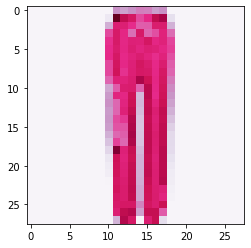

In [18]:
ind=1000
print (labelsDict[y_train[ind]])
plt.imshow(np.reshape(X_train[ind],(28,28)),cmap=plt.get_cmap('PuRd'))

In [19]:
X_train[ind].shape

(784,)

In [20]:
#randomly selet a value of the range input
np.random.seed(11)
inds=np.random.choice(np.arange(0,60000), size=30000, replace = False)

In [21]:
inds

array([17110, 52027, 54904, ..., 15986, 55367, 26430])

In [22]:
X_small=X_train[inds,:]
y_small=y_train[inds]

In [23]:
#fit KMeans Model
kmeanModel=MiniBatchKMeans(n_clusters=7, random_state=11).fit(X_train)

In [24]:
clusterLabels = kmeanModel.labels_
len(clusterLabels)

60000

In [25]:
np.unique(clusterLabels)

array([0, 1, 2, 3, 4, 5, 6])

In [26]:
clusterDf=pd.DataFrame({'labelCodes':y_train,'clusters':clusterLabels})

In [27]:
clusterDf

,labelCodes,clusters
0,9,4
1,0,3
2,0,2
3,3,2
4,0,5
...,...,...
59995,5,1
59996,1,5
59997,3,3
59998,0,2


In [28]:
clusterDf['labels']=clusterDf.labelCodes.map(labelsDict)
clusterDf

,labelCodes,clusters,labels
0,9,4,Ankle boot
1,0,3,T-shirt/top
2,0,2,T-shirt/top
3,3,2,Dress
4,0,5,T-shirt/top
...,...,...,...
59995,5,1,Sandal
59996,1,5,Trouser
59997,3,3,Dress
59998,0,2,T-shirt/top


In [29]:
clusterDf.clusters.value_counts()

0    11916
2    11404
1    10060
5     8998
3     8132
6     6200
4     3290
Name: clusters, dtype: int64

In [30]:
clusterDf.labels.value_counts()

Dress          6000
Sneaker        6000
Sandal         6000
Bag            6000
Shirt          6000
Pullover       6000
T-shirt/top    6000
Trouser        6000
Ankle boot     6000
Coat           6000
Name: labels, dtype: int64

In [31]:
#enlarge output length limit
pd.set_option('display.max_rows',500)
clusterDf.groupby('clusters')['labels'].value_counts()

clusters  labels     
0         Pullover       3908
          Coat           3879
          Shirt          2258
          Bag            1514
          T-shirt/top     220
          Trouser          75
          Dress            57
          Ankle boot        4
          Sandal            1
1         Sneaker        5267
          Sandal         4134
          Bag             320
          Ankle boot      315
          Shirt            12
          T-shirt/top       8
          Pullover          3
          Coat              1
2         Shirt          2417
          Pullover       1912
          T-shirt/top    1817
          Bag            1589
          Sandal         1174
          Dress          1084
          Coat            996
          Trouser         274
          Ankle boot      137
          Sneaker           4
3         T-shirt/top    3734
          Dress          1717
          Shirt          1229
          Coat            952
          Trouser         253
          Pullover

In [34]:
label6=clusterDf[clusterDf.clusters==6]
print(label6[label6.labels=='Ankle boot'].index[0])
print(label6[label6.labels=='Bag'].index[0])

15
23


In [37]:
coMat=clusterDf.groupby('clusters')['labels'].value_counts()
#replace NA with 0
coMat=coMat.unstack().fillna(0)
#transpose it in order to read more convenient
coMat=coMat.T

In [39]:
#数数各组里各分类的数量
coMat

clusters,0,1,2,3,4,5,6
labels,,,,,,,
Ankle boot,4.0,315.0,137.0,3.0,2915.0,3.0,2623.0
Bag,1514.0,320.0,1589.0,86.0,11.0,15.0,2465.0
Coat,3879.0,1.0,996.0,952.0,0.0,164.0,8.0
Dress,57.0,0.0,1084.0,1717.0,0.0,3141.0,1.0
Pullover,3908.0,3.0,1912.0,156.0,0.0,8.0,13.0
Sandal,1.0,4134.0,1174.0,2.0,333.0,1.0,355.0
Shirt,2258.0,12.0,2417.0,1229.0,1.0,61.0,22.0
Sneaker,0.0,5267.0,4.0,0.0,29.0,0.0,700.0
T-shirt/top,220.0,8.0,1817.0,3734.0,1.0,208.0,12.0


In [40]:
cosMat=cosine_similarity(coMat)
cosMat.shape

(10, 10)

A cosine value of 0 means that the two vectors are at 90 degrees to each other (orthogonal) and have no match. The closer the cosine value to 1, the smaller the angle and the greater the match between vectors.

In [41]:
#对角对称
cosMat=pd.DataFrame(cosMat,index=coMat.index, columns=coMat.index)
cosMat
#越接近1，越相似

labels,Ankle boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
labels,,,,,,,,,,
Ankle boot,1.000000,0.522498,0.010891,0.011269,0.018271,0.197648,0.029400,0.171177,0.018215,0.002696
Bag,0.522498,1.000000,0.553198,0.161668,0.623318,0.283610,0.634150,0.193904,0.258964,0.036447
Coat,0.010891,0.553198,1.000000,0.223908,0.959765,0.066352,0.849172,0.000678,0.364489,0.075813
Dress,0.011269,0.161668,0.223908,1.000000,0.158944,0.079095,0.382577,0.000253,0.580864,0.873973
Pullover,0.018271,0.623318,0.959765,0.158944,1.000000,0.120346,0.887649,0.001407,0.271328,0.038195
Sandal,0.197648,0.283610,0.066352,0.079095,0.120346,1.000000,0.190000,0.958943,0.120989,0.014018
Shirt,0.029400,0.634150,0.849172,0.382577,0.887649,0.190000,1.000000,0.004709,0.645864,0.077080
Sneaker,0.171177,0.193904,0.000678,0.000253,0.001407,0.958943,0.004709,1.000000,0.002614,0.000062
T-shirt/top,0.018215,0.258964,0.364489,0.580864,0.271328,0.120989,0.645864,0.002614,1.000000,0.114602


sneaker & sandal are similar  
higher more similar

In [42]:
Z=hierarchy.linkage(cosMat)

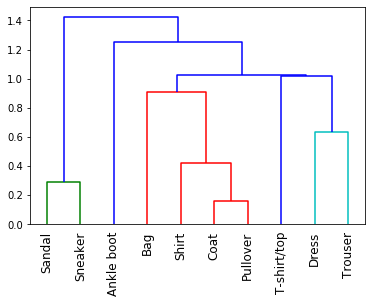

In [43]:
dn=hierarchy.dendrogram(Z, labels=cosMat.columns,leaf_rotation=90)

In [44]:
from scipy.spatial.distance import cdist

In [45]:
cents=kmeanModel.cluster_centers_
cents.shape

(7, 784)

In [46]:
distortions=[]
for k in np.arange(2,30):
    model=MiniBatchKMeans(n_clusters=k, random_state=11).fit(X_train)
    distortions.append(np.sum(np.min(cdist(X_train, model.cluster_centers_,'euclidean'),axis=1))/X_train.shape[0])

Text(0, 0.5, 'Distortions')

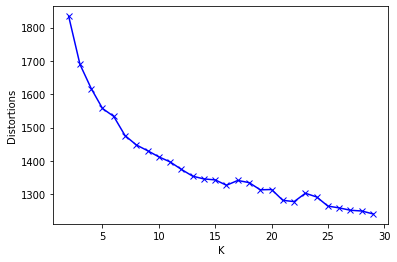

In [47]:
plt.plot(np.arange(2,30),distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortions')

In [48]:
#fit the first two components


In [49]:
pca=PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
pca.explained_variance_ratio_

array([0.29039228, 0.1775531 ])

In [51]:
reduced=pca.transform(X_train)

In [52]:
df=pd.DataFrame(reduced,columns=['X','Y'])
df.head()

,X,Y
0,-123.993791,1633.074396
1,1407.928853,-451.641336
2,-725.910795,-1101.838138
3,31.398664,-981.067672
4,804.119258,-1201.168720


In [53]:
df['labelCodes']=y_train
df['labels']=df.labelCodes.map(labelsDict)

In [54]:
df.head()

,X,Y,labelCodes,labels
0,-123.993791,1633.074396,9,Ankle boot
1,1407.928853,-451.641336,0,T-shirt/top
2,-725.910795,-1101.838138,0,T-shirt/top
3,31.398664,-981.067672,3,Dress
4,804.119258,-1201.168720,0,T-shirt/top


In [55]:
means=df.groupby('labels')[['X','Y']].mean()
means

,X,Y
labels,,
Ankle boot,-557.836864,1100.992688
Bag,43.658760,880.205153
Coat,1059.289340,210.994924
Dress,282.555700,-1042.590808
Pullover,861.536311,330.556600
Sandal,-1499.340028,120.356565
Shirt,583.638253,-39.736501
Sneaker,-1474.973984,404.107214
T-shirt/top,685.822396,-610.317773


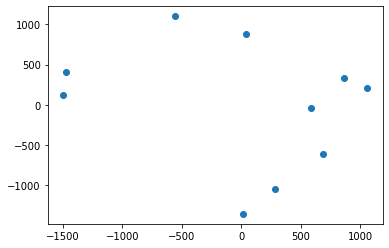

In [56]:
plt.scatter(means.X,means.Y)

In [57]:
cents=pca.transform(cents)

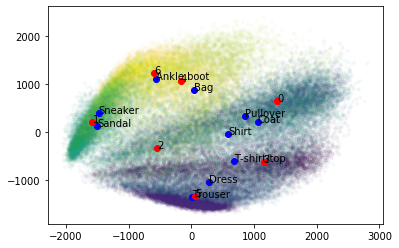

In [58]:
fig, ax=plt.subplots()
plt.scatter(df.X,df.Y, alpha=0.03,marker='.',c=df.labelCodes)
plt.scatter(means.X,means.Y,color='b')
plt.scatter(cents[:,0],cents[:,1],color='r')
for i in range(len(means)):
    ax.annotate(means.index[i],(means.X.iloc[i],means.Y.iloc[i]))

for i in range(len(cents)):
    ax.annotate(i,(cents[i,0],cents[i,1]))